# Prey predator braitenberg notebook

Use this notebook to showcase how to build on top of an existing environment

## Imports

In [1]:
from enum import Enum
from functools import partial
from typing import Tuple

import jax.numpy as jnp

from jax import vmap, jit
from jax import random
from flax import struct

from vivarium.experimental.environments.braitenberg.simple import BraitenbergEnv, AgentState, State, EntityType
from vivarium.experimental.environments.braitenberg.simple import sensorimotor, compute_prox, behavior_name_map
from vivarium.experimental.environments.base_env import BaseEntityState, BaseObjectState

2024-06-03 15:47:34.147139: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


### Define the states classes of prey predator env 

In [2]:
### Define the classes and constants of the environment (most of them inherit from the simple braitenbeg one) ###

class AgentType(Enum):
    PREY = 0
    PREDATOR = 1

predator_color = jnp.array([1., 0., 0.])
prey_color = jnp.array([0., 0., 1.])
object_color = jnp.array([0., 1., 0.])

@struct.dataclass
class EntityState(BaseEntityState):
  pass
    
@struct.dataclass
class AgentState(AgentState):
    agent_type: jnp.array

@struct.dataclass
class ObjectState(BaseObjectState):
    pass

@struct.dataclass
class State(State):
    pass

### Define prey predator env class 

(inheriting from simple Braitenberg env)

In [3]:

### Define the new env class inheriting from simple one (only need to update __init__, init_state and _step)

class PreyPredBraitenbergEnv(BraitenbergEnv):
    def __init__(
            self,
            box_size=200,
            dt=0.1,
            max_agents=50,
            max_objects=10,
            neighbor_radius=100.,
            collision_alpha=0.5,
            collision_eps=0.1,
            n_dims=2,
            seed=0,
            diameter=5.0,
            friction=0.1,
            mass_center=1.0,
            mass_orientation=0.125,
            existing_agents=50,
            existing_objects=10,
            wheel_diameter=2.0,
            speed_mul=1.0,
            max_speed=10.0,
            theta_mul=1.0,
            prox_dist_max=40.0,
            prox_cos_min=0.0,
            objects_color=jnp.array([0.0, 1.0, 0.0]),
            # New prey_predators args, should maybe add warnings to avoid incompatible values (e.g less agents than prey + pred)
            n_preys=25,
            n_predators=25,
            pred_eating_range=10,
            prey_color=jnp.array([0.0, 0.0, 1.0]),
            predator_color=jnp.array([1.0, 0.0, 0.0]),
    ):
        super().__init__(
            box_size=box_size,
            dt=dt,
            max_agents=max_agents,
            max_objects=max_objects,
            neighbor_radius=neighbor_radius,
            collision_alpha=collision_alpha,
            collision_eps=collision_eps,
            n_dims=n_dims,
            seed=seed,
            diameter=diameter,
            friction=friction,
            mass_center=mass_center,
            mass_orientation=mass_orientation,
            existing_agents=existing_agents,
            existing_objects=existing_objects,
            wheel_diameter=wheel_diameter,
            speed_mul=speed_mul,
            max_speed=max_speed,
            theta_mul=theta_mul,
            prox_dist_max=prox_dist_max,
            prox_cos_min=prox_cos_min,
            objects_color=objects_color
        )
        # Add specific attributes about prey / predator environment
        self.n_preys = n_preys
        self.n_predators = n_predators
        self.prey_color = prey_color
        self.predator_color = predator_color
        self.pred_eating_range = pred_eating_range

    def init_state(self) -> State:
        key = random.PRNGKey(self.seed)
        key, key_agents_pos, key_objects_pos, key_orientations = random.split(key, 4)

        entities = self.init_entities(key_agents_pos, key_objects_pos, key_orientations)
        objects = self.init_objects()

        # Added agent types for prey and predators
        agent_types = jnp.hstack((jnp.full(self.n_preys, AgentType.PREY.value), jnp.full(self.n_predators, AgentType.PREDATOR.value)))
        agents_colors = jnp.concatenate((jnp.tile(self.prey_color, (self.n_preys, 1)), jnp.tile(self.predator_color, (self.n_predators, 1))), axis=0)
        behaviors = jnp.hstack((jnp.full(self.n_preys, behavior_name_map['FEAR']), jnp.full(self.n_predators, behavior_name_map['AGGRESSION'])))

        agents = AgentState(
            # idx in the entities (ent_idx) state to map agents information in the different data structures
            ent_idx=jnp.arange(self.max_agents, dtype=int),
            agent_type=agent_types, 
            prox=jnp.zeros((self.max_agents, 2)),
            motor=jnp.zeros((self.max_agents, 2)),
            behavior=behaviors,
            wheel_diameter=jnp.full((self.max_agents), self.wheel_diameter),
            speed_mul=jnp.full((self.max_agents), self.speed_mul),
            max_speed=jnp.full((self.max_agents), self.max_speed),
            theta_mul=jnp.full((self.max_agents), self.theta_mul),
            proxs_dist_max=jnp.full((self.max_agents), self.prox_dist_max),
            proxs_cos_min=jnp.full((self.max_agents), self.prox_cos_min),
            proximity_map_dist=jnp.zeros((self.max_agents, 1)),
            proximity_map_theta=jnp.zeros((self.max_agents, 1)),
            color=agents_colors
            )

        state = self.init_complete_state(entities, agents, objects)
        # Create jax_md attributes for environment physics
        state = self.init_env_physics(key, state)

        self.agents_idx = jnp.where(state.entities.entity_type == EntityType.AGENT.value)
        self.prey_idx = jnp.where(state.agents.agent_type == AgentType.PREY.value)
        self.pred_idx = jnp.where(state.agents.agent_type == AgentType.PREDATOR.value)

        return state
    
    def can_all_be_eaten(self, R_prey, R_predators, predator_exist):
        # Could maybe create this as a method in the class, or above idk
        distance_to_all_preds = vmap(self.distance, in_axes=(None, 0))

        # Same for this, the only pb is that the fn above needs the displacement arg, so can't define it in the cell above 
        def can_be_eaten(R_prey, R_predators, predator_exist):
            dist_to_preds = distance_to_all_preds(R_prey, R_predators)
            in_range = jnp.where(dist_to_preds < self.pred_eating_range, 1, 0)
            # Could also return which agent ate the other one (e.g to increase their energy) 
            will_be_eaten_by = in_range * predator_exist
            eaten_or_not = jnp.where(jnp.sum(will_be_eaten_by) > 0., 1, 0)

            return eaten_or_not
        
        can_be_eaten = vmap(can_be_eaten, in_axes=(0, None, None))
        
        return can_be_eaten(R_prey, R_predators, predator_exist)
    
    def eat_preys(self, state):
        # See which preys can be eaten by predators and update the exists array accordingly
        R = state.entities.position.center
        exist = state.entities.exists
        prey_idx = self.prey_idx
        pred_idx = self.pred_idx

        agents_ent_idx = state.agents.ent_idx
        predator_exist = exist[agents_ent_idx][pred_idx]
        can_be_eaten_idx = self.can_all_be_eaten(R[prey_idx], R[pred_idx], predator_exist)

        # Kill the agents that are being eaten
        exist_prey = exist[agents_ent_idx[prey_idx]]
        new_exists_prey = jnp.where(can_be_eaten_idx == 1, 0, exist_prey)
        exist = exist.at[agents_ent_idx[prey_idx]].set(new_exists_prey)

        return exist

    @partial(jit, static_argnums=(0,))
    def _step(self, state: State, neighbors: jnp.array, agents_neighs_idx: jnp.array) -> Tuple[State, jnp.array]:
        # 1 Compute which agents are being eaten
        exist = self.eat_preys(state)
        entities = state.entities.replace(exists=exist)

        # 2 Compute the proximeter of agents
        exists_mask = jnp.where(entities.exists == 1, 1, 0)
        prox, proximity_dist_map, proximity_dist_theta = compute_prox(state, agents_neighs_idx, target_exists_mask=exists_mask, displacement=self.displacement)
        motor = sensorimotor(prox, state.agents.behavior, state.agents.motor)
        agents = state.agents.replace(
            prox=prox, 
            proximity_map_dist=proximity_dist_map, 
            proximity_map_theta=proximity_dist_theta,
            motor=motor
        )

        # 3 Update the state with the new agent and entities states
        state = state.replace(
            agents=agents,
            entities=entities
        )

        # 4 Apply physics forces to the environment state
        entities = self.apply_physics(state, neighbors)
        state = state.replace(
            time=state.time+1,
            entities=entities,
        )

        # 5 Update the neighbors according to the new positions
        neighbors = neighbors.update(state.entities.position.center)
        return state, neighbors

### Create env and render its state

In [4]:
from vivarium.experimental.environments.braitenberg.utils import render, render_history

In [5]:
env = PreyPredBraitenbergEnv()
state = env.init_state()

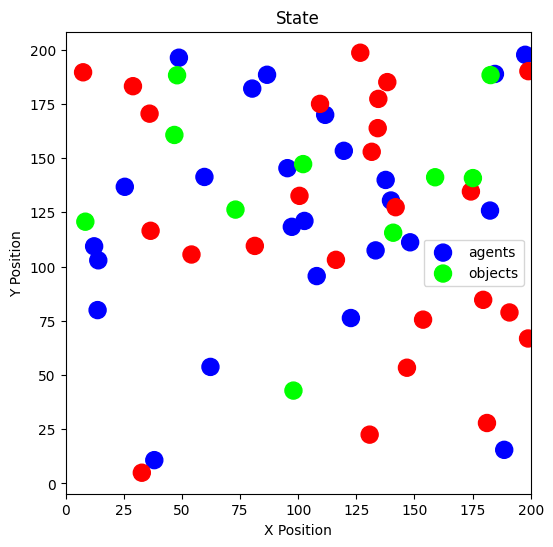

In [6]:
render(state)

- Prey agents: blue
- Predator agents: red
- Objects: green

### Run a simulation on a few timesteps

In [7]:
n_steps = 2000

hist = []
for i in range(n_steps):
    state = env.step(state)
    hist.append(state)

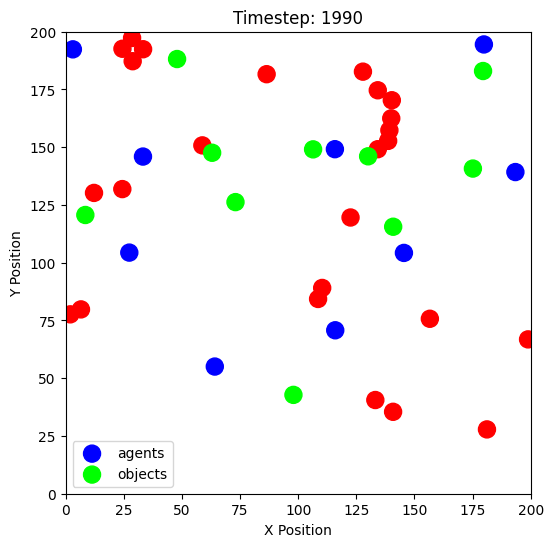

In [8]:
render_history(hist, skip_frames=10)

# The rendering function is quite laggy, I'll change it later (but at the moment it works to test the environments rapidly)